In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import h5py
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
! pip install PyWavelets
import pywt
import seaborn as sns
print(torch.__version__)  # Check PyTorch version
print(torch.cuda.is_available())  # Should return True if CUDA is available

Defaulting to user installation because normal site-packages is not writeable
2.6.0+cu126
True


In [14]:
def wavelet_transform(signal, wavelet='db4', level=3):
    """
    Apply Discrete Wavelet Transform (DWT) on an RF signal.

    Args:
        signal (numpy array): Raw RF signal (48000, 1024, 2).
        wavelet (str): Type of wavelet to use (default = 'db4').
        level (int): Number of decomposition levels.

    Returns:
        Transformed signal (numpy array of the same shape).
    """
    transformed_signal = np.zeros_like(signal, dtype=np.float32)

    for index in range(signal.shape[0]):
        real_part = signal[index, :, 0]
        imag_part = signal[index, :, 1]

        # Convert to complex numbers
        complex_signal = real_part + 1j * imag_part

        # Apply Wavelet Transform (DWT)
        coeffs = pywt.wavedec(complex_signal, wavelet, level=level)

        # Select **only the first (largest) coefficient array** instead of concatenation
        approx_coeffs = coeffs[0]

        # Trim or pad to 1024
        if len(approx_coeffs) > 1024:
            approx_coeffs = approx_coeffs[:1024]
        elif len(approx_coeffs) < 1024:
            approx_coeffs = np.pad(approx_coeffs, (0, 1024 - len(approx_coeffs)), mode='constant')

        # Store transformed data
        transformed_signal[index, :, 0] = approx_coeffs.real
        transformed_signal[index, :, 1] = approx_coeffs.imag

    return transformed_signal

In [15]:
# Dataset Preparation
class H5Dataset(Dataset):
    def __init__(self, file_list, idx, transform=None):
        self.data = []
        self.labels = []
        self.snr = []
        for file in file_list:
            with h5py.File(file, 'r') as f:
                self.data.append(f['X'][:][idx])
                self.labels.append(f['Y'][:][idx])
                self.snr.append(f['Z'][:][idx])
        self.data = np.vstack(self.data)
        self.labels = np.vstack(self.labels)
        self.snr = np.vstack(self.snr)
        #self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        z = self.snr[idx]
        # x = wavelet_transform(x)
        #if self.transform:
        #    x = self.transform(x)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(z, dtype=torch.float32)

In [16]:
# Transformer Components
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8):

        super(MultiHeadSelfAttention, self).__init__()
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Conv2d):
                torch.nn.init.xavier_uniform_(layer.weight)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads

        self.query_dense = nn.Linear(embed_dim, embed_dim, bias=False)
        self.key_dense = nn.Linear(embed_dim, embed_dim, bias=False)
        self.value_dense = nn.Linear(embed_dim, embed_dim, bias=False)
        self.combine_heads = nn.Linear(embed_dim, embed_dim)

    def attention(self, query, key, value):
        score = torch.matmul(query, key.transpose(-2, -1))
        dim_key = torch.tensor(key.shape[-1], dtype=torch.float32)
        scaled_score = score / torch.sqrt(dim_key + 1e-9)
        weights = torch.softmax(scaled_score, dim=-1)
        output = torch.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.projection_dim)
        return x.permute(0, 2, 1, 3)

    def forward(self, inputs):
        batch_size = inputs.shape[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, _ = self.attention(query, key, value)
        attention = attention.permute(0, 2, 1, 3).contiguous()
        concat_attention = attention.view(batch_size, -1, self.embed_dim)
        output = self.combine_heads(concat_attention)
        return output

In [17]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.2):
        super(TransformerBlock, self).__init__()
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Conv2d):
                torch.nn.init.xavier_uniform_(layer.weight)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, inputs):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [18]:
# Model Definition
def proposed_model(X_train_shape, num_classes):
    embed_dim = 1024  # Embedding size for each token
    num_heads = 128  # Number of attention heads
    ff_dim = 256  # Hidden layer size in feed forward network inside transformer

    class Model(nn.Module):
      def __init__(self):

        super(Model, self).__init__()
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Conv2d):
                torch.nn.init.xavier_uniform_(layer.weight)
        self.reshape = nn.Linear(X_train_shape[-1], 1024*2)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.batch_norm = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(0.3)
        self.dense1 = nn.Linear(embed_dim, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(128, 128)
        self.dropout3 = nn.Dropout(0.2)
        self.output_layer = nn.Linear(128, num_classes)

      def forward(self, x):
          x = x.view(-1, 2, 1024)
          x = self.transformer_block(x)
          x = self.global_avg_pool(x.transpose(1, 2)).squeeze(-1)
          x = self.batch_norm(x)
          x = self.dropout1(torch.selu(self.dense1(x)))
          x = self.dropout2(torch.selu(self.dense2(x)))
          x = self.dropout3(x)
          x = torch.softmax(self.output_layer(x), dim=-1)
          return x
    return Model()


In [19]:
#from sklearn.metrics import ConfusionMatrixDisplay
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for inputs, labels, snr in train_loader:
            inputs, labels, snr = inputs.to(device), labels.to(device), snr.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels.max(1)[1]).sum().item()

        train_acc = 100. * correct / total
        train_losses.append(train_loss / total)
        train_accuracies.append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / total:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Plotting Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, val_loader, criterion):
  model.eval()
  val_loss = 0
  correct = 0
  total = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  with torch.no_grad():
      for inputs, labels, snr in val_loader:
          inputs, labels, snr = inputs.to(device), labels.to(device), snr.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          val_loss += loss.item() * inputs.size(0)
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += (predicted == labels.max(1)[1]).sum().item()

  val_loss /= total
  val_acc = 100. * correct / total
  return val_loss, val_acc

# Confusion Matrix Plot
# def plot_confusion_matrix(y_true, y_pred, classes):
#     cm = confusion_matrix(y_true, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
#     disp.plot(cmap=plt.cm.Blues)
#     plt.show()

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import shutil

##############################全局参数#######################################
f = h5py.File(r'dataset\GOLD_XYZ_OSC.0001_1024.hdf5','r')
dir_path = r'ExtractDataset'
if os.path.exists(dir_path):
    # Remove the directory
    shutil.rmtree(dir_path)
    print(f"Deleted: {dir_path}")
    # Recreate the directory
    os.mkdir(dir_path)
modu_snr_size = 1200
############################################################################

for modu in range(24):
	X_list = []
	Y_list = []
	Z_list = []
	print('part ',modu)
	start_modu = modu*106496
	for snr in range(26):
		start_snr = start_modu + snr*4096
		idx_list = np.random.choice(range(0,4096),size=modu_snr_size,replace=False)
		X = f['X'][start_snr:start_snr+4096][idx_list]
		#X = X[:,0:768,:]
		X_list.append(X)
		Y_list.append(f['Y'][start_snr:start_snr+4096][idx_list])
		Z_list.append(f['Z'][start_snr:start_snr+4096][idx_list])

	filename = dir_path + '/part' + str(modu) + '.h5'
	fw = h5py.File(filename,'w')
	fw['X'] = np.vstack(X_list)
	fw['Y'] = np.vstack(Y_list)
	fw['Z'] = np.vstack(Z_list)
	print('X shape:',fw['X'].shape)
	print('Y shape:',fw['Y'].shape)
	print('Z shape:',fw['Z'].shape)
	fw.close()
f.close()

Deleted: ExtractDataset
part  0
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  1
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  2
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  3
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  4
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  5
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  6
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  7
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  8
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  9
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  10
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  11
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1)
part  12
X shape: (31200, 1024, 2)
Y shape: (31200, 24)
Z shape: (31200, 1

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# Main
if __name__ == "__main__":
# File paths and dataset split
    batch_size = 1024
    dir_path =  'to_download'#'drive/MyDrive/Colab Notebooks/dataSet'
    f = h5py.File(dir_path + r'/part0.h5')

    sample_num = f['X'].shape[0]
    file_list = [dir_path + f"/part{i}.h5" for i in range(24)]
    idx = np.random.choice(range(0,sample_num),size=60000)

    train_size = int(0.8 * len(idx))
    train_idx, test_idx = idx[:train_size], idx[train_size:]

    train_dataset = H5Dataset(file_list, train_idx)
    test_dataset = H5Dataset(file_list, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
print(torch.cuda.is_available())
print(torch.__version__)

True
2.6.0+cu126


Epoch 1/300, Train Loss: 0.7086, Train Acc: 16.63%, Val Loss: 0.7070, Val Acc: 20.38%
Epoch 2/300, Train Loss: 0.7068, Train Acc: 20.99%, Val Loss: 0.7065, Val Acc: 21.95%
Epoch 3/300, Train Loss: 0.7063, Train Acc: 22.34%, Val Loss: 0.7061, Val Acc: 23.07%
Epoch 4/300, Train Loss: 0.7059, Train Acc: 23.57%, Val Loss: 0.7058, Val Acc: 24.13%
Epoch 5/300, Train Loss: 0.7054, Train Acc: 25.00%, Val Loss: 0.7055, Val Acc: 25.05%
Epoch 6/300, Train Loss: 0.7050, Train Acc: 26.11%, Val Loss: 0.7050, Val Acc: 26.51%
Epoch 7/300, Train Loss: 0.7046, Train Acc: 27.08%, Val Loss: 0.7048, Val Acc: 26.76%
Epoch 8/300, Train Loss: 0.7044, Train Acc: 27.74%, Val Loss: 0.7049, Val Acc: 26.48%
Epoch 9/300, Train Loss: 0.7042, Train Acc: 28.36%, Val Loss: 0.7046, Val Acc: 27.31%
Epoch 10/300, Train Loss: 0.7040, Train Acc: 28.84%, Val Loss: 0.7043, Val Acc: 28.08%
Epoch 11/300, Train Loss: 0.7038, Train Acc: 29.29%, Val Loss: 0.7042, Val Acc: 28.33%
Epoch 12/300, Train Loss: 0.7037, Train Acc: 29.71%,

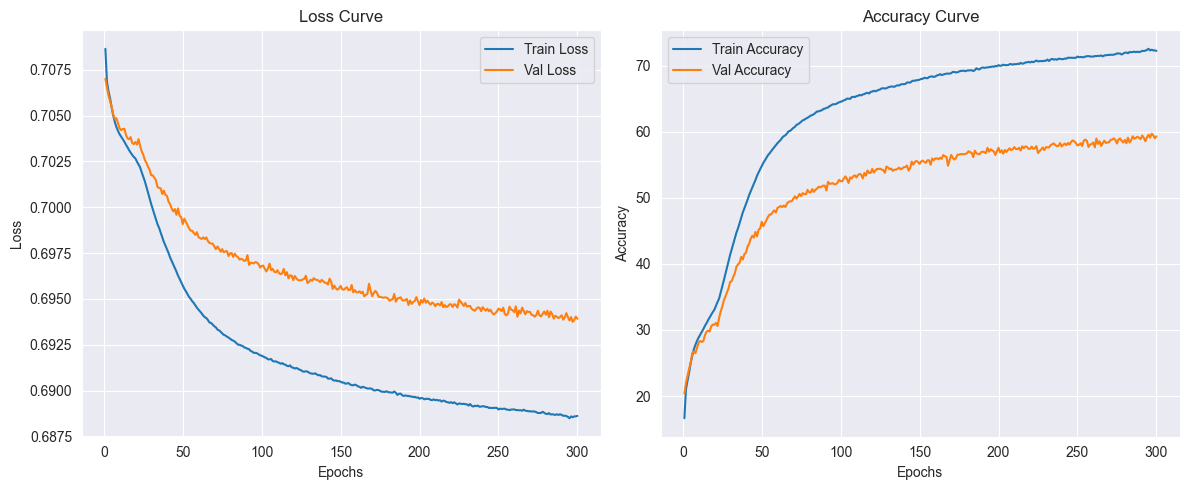

In [22]:
# Model, Loss, Optimizer
input_shape = train_dataset[0][0].shape
num_classes = 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = proposed_model(input_shape, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train and Evaluate
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=300)



In [23]:
torch.save(model.state_dict(), 'Rf-finger-print-model.pth')

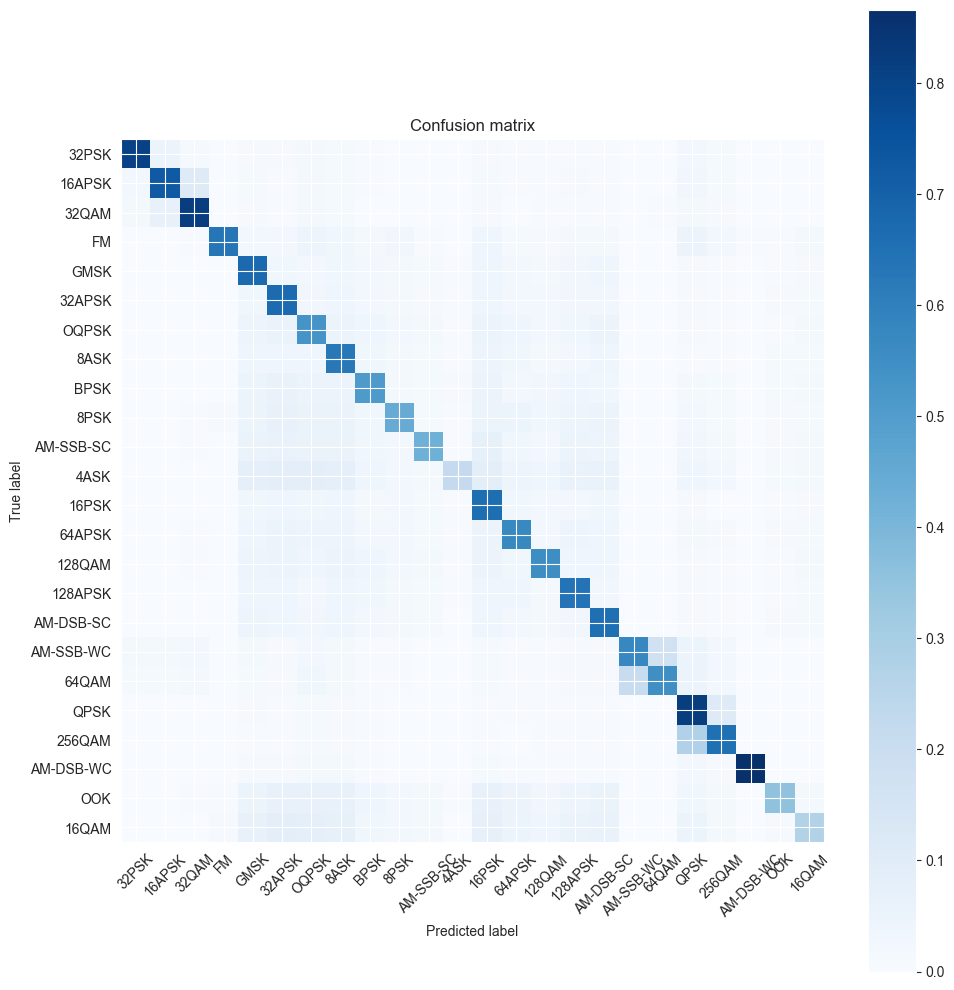

In [24]:
# Confusion Matrix
y_true = []
y_pred = []
outputs_test = []
model.eval()
with torch.no_grad():
    for inputs, labels , snr in test_loader:
        inputs, labels, snr = inputs.to(device), labels.to(device), snr.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        outputs_test.extend(outputs.cpu().numpy())
        y_true.extend(labels.max(1)[1].cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
classes=["32PSK", "16APSK", "32QAM", "FM", "GMSK", "32APSK", "OQPSK", "8ASK", "BPSK", "8PSK", "AM-SSB-SC", "4ASK", "16PSK", "64APSK", "128QAM", "128APSK", "AM-DSB-SC", "AM-SSB-WC", "64QAM", "QPSK", "256QAM", "AM-DSB-WC", "OOK", "16QAM"]
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
outputs_test= np.array(outputs_test)
for i in range(0, len(test_dataset)):
    j = list(test_dataset.labels[i,:]).index(1)
    k = int(np.argmax(outputs_test[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
# plot_confusion_matrix(y_true, y_pred, classes=["32PSK", "16APSK", "32QAM", "FM", "GMSK", "32APSK", "OQPSK", "8ASK", "BPSK", "8PSK", "AM-SSB-SC", "4ASK", "16PSK", "64APSK", "128QAM", "128APSK", "AM-DSB-SC", "AM-SSB-WC", "64QAM", "QPSK", "256QAM", "AM-DSB-WC", "OOK", "16QAM"])

Overall Accuracy -20:  0.5096078431372549
Overall Accuracy -18:  0.5042048929663608
Overall Accuracy -16:  0.521499644633973
Overall Accuracy -14:  0.5332618025751072
Overall Accuracy -12:  0.5580524344569289
Overall Accuracy -10:  0.5769021739130434
Overall Accuracy -8:  0.6227973568281938
Overall Accuracy -6:  0.6363715277777777
Overall Accuracy -4:  0.6695736434108527
Overall Accuracy -2:  0.6774822695035461


C:\Users\user1\AppData\Local\Temp\ipykernel_2904\3583432898.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Overall Accuracy 0:  0.6739207360226469
Overall Accuracy 2:  0.6405336257309941
Overall Accuracy 4:  0.6277997364953887
Overall Accuracy 6:  0.6073024054982817
Overall Accuracy 8:  0.5935977731384829
Overall Accuracy 10:  0.5921803652968036
Overall Accuracy 12:  0.5868451025056948
Overall Accuracy 14:  0.5746972934472935
Overall Accuracy 16:  0.5897090517241379
Overall Accuracy 18:  0.6050189393939394
Overall Accuracy 20:  0.5862099023709902
Overall Accuracy 22:  0.582089552238806
Overall Accuracy 24:  0.5875809061488673
Overall Accuracy 26:  0.592941998602376
Overall Accuracy 28:  0.572325327510917
Overall Accuracy 30:  0.5802213001383126


<Figure size 640x480 with 0 Axes>

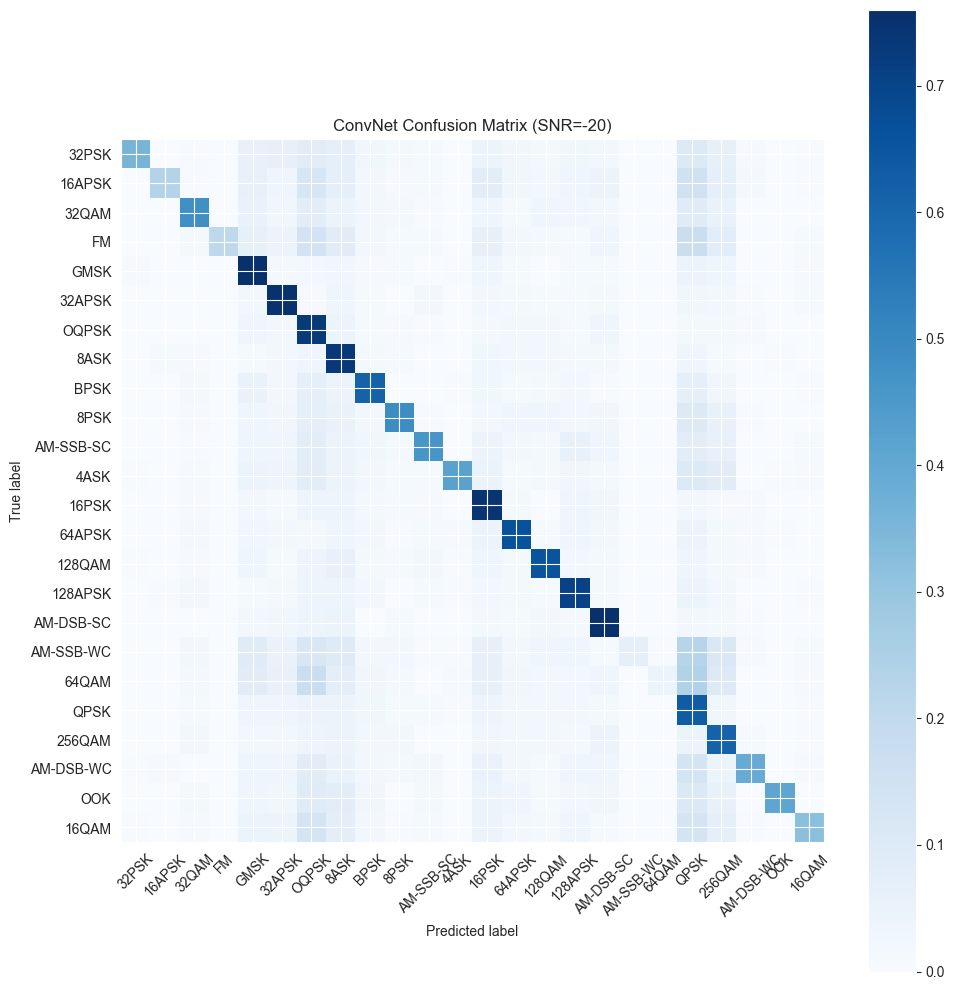

<Figure size 640x480 with 0 Axes>

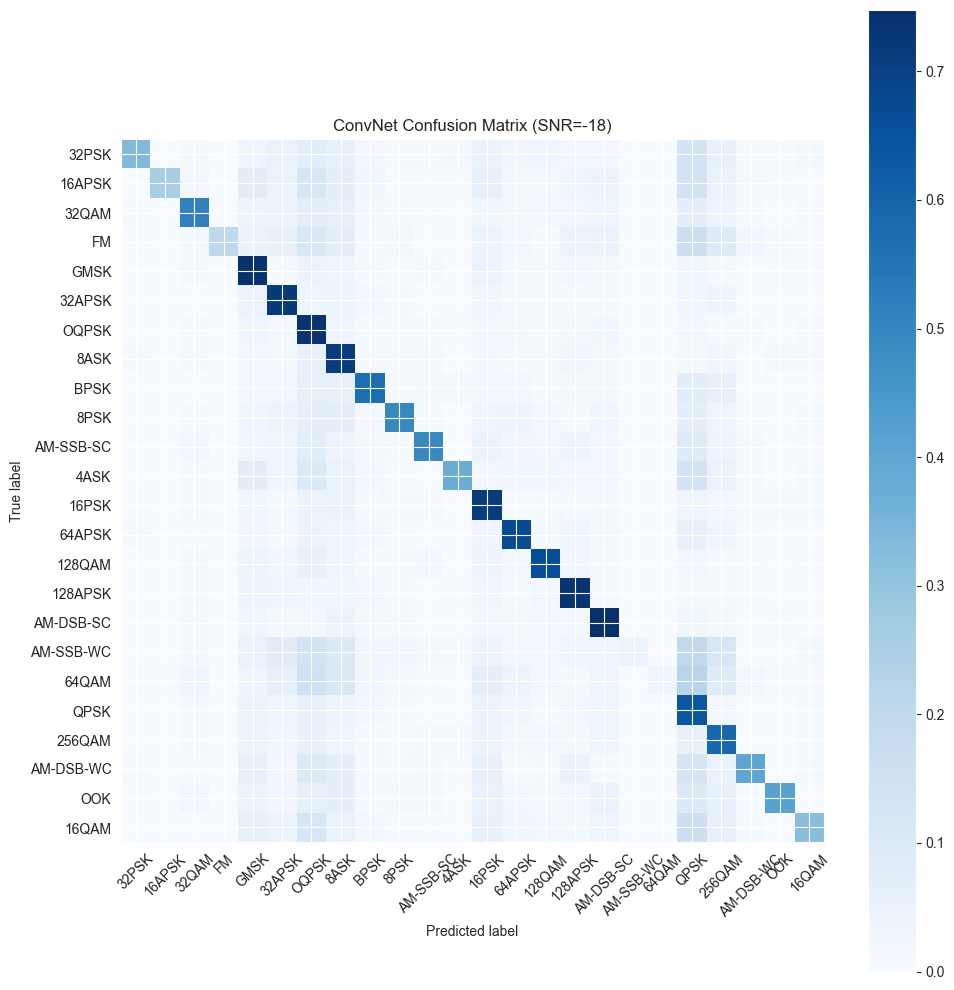

<Figure size 640x480 with 0 Axes>

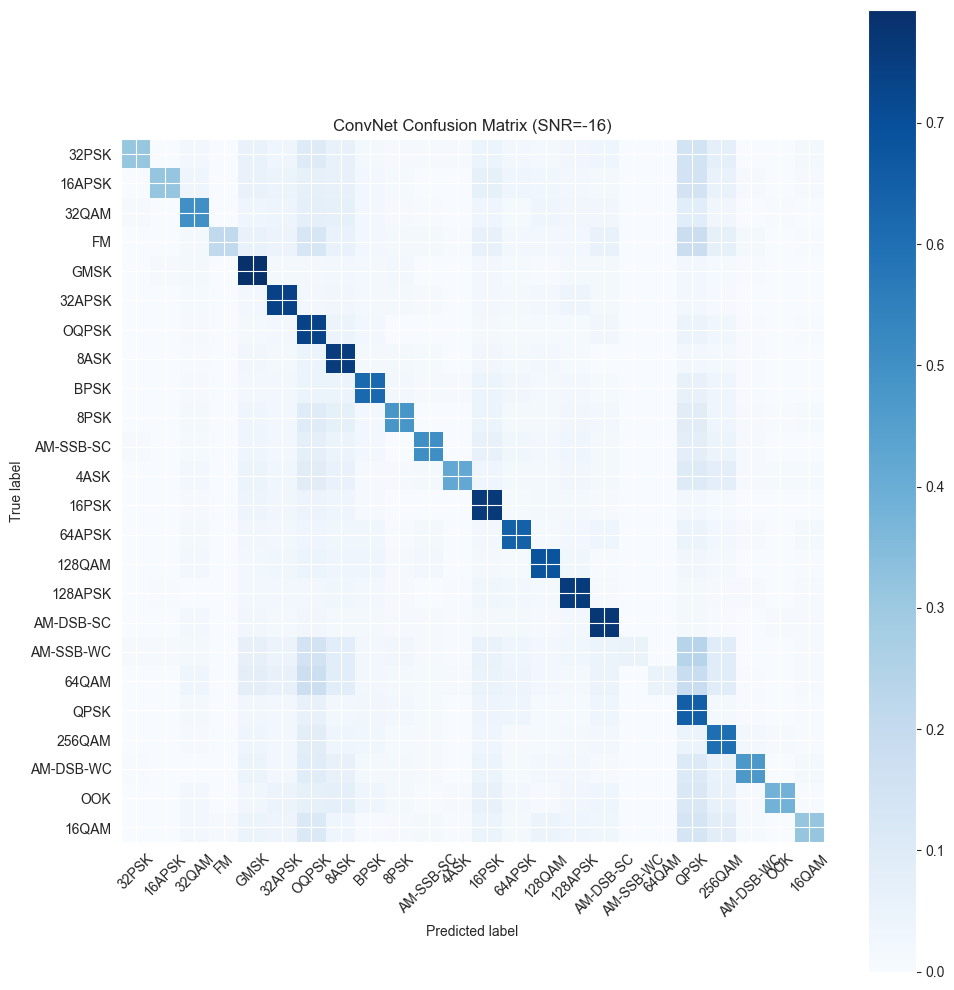

<Figure size 640x480 with 0 Axes>

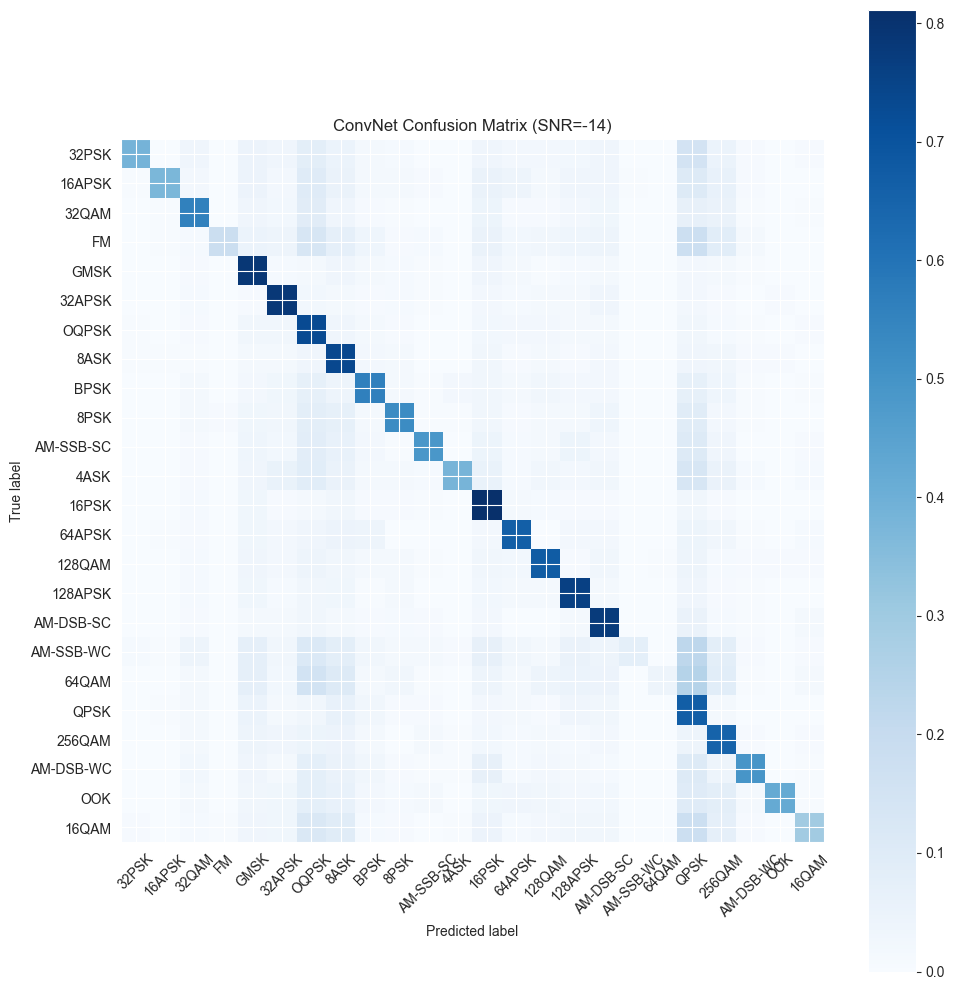

<Figure size 640x480 with 0 Axes>

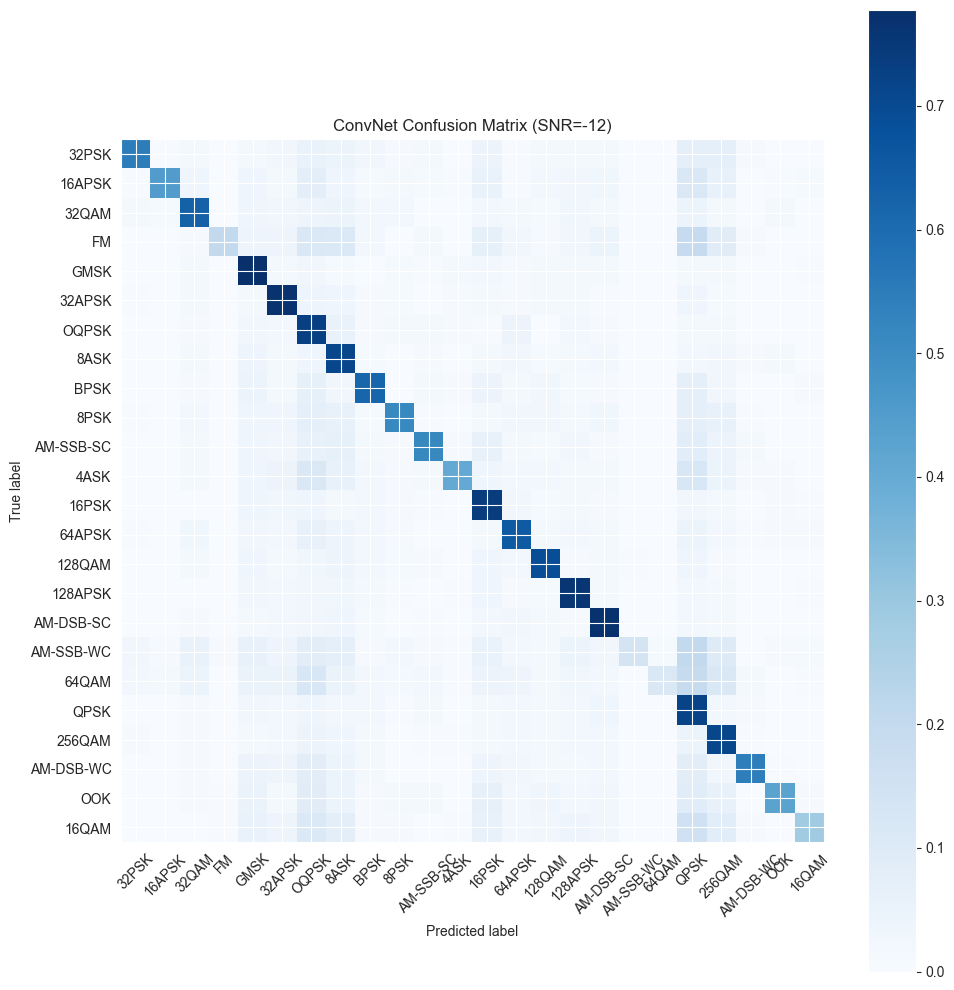

<Figure size 640x480 with 0 Axes>

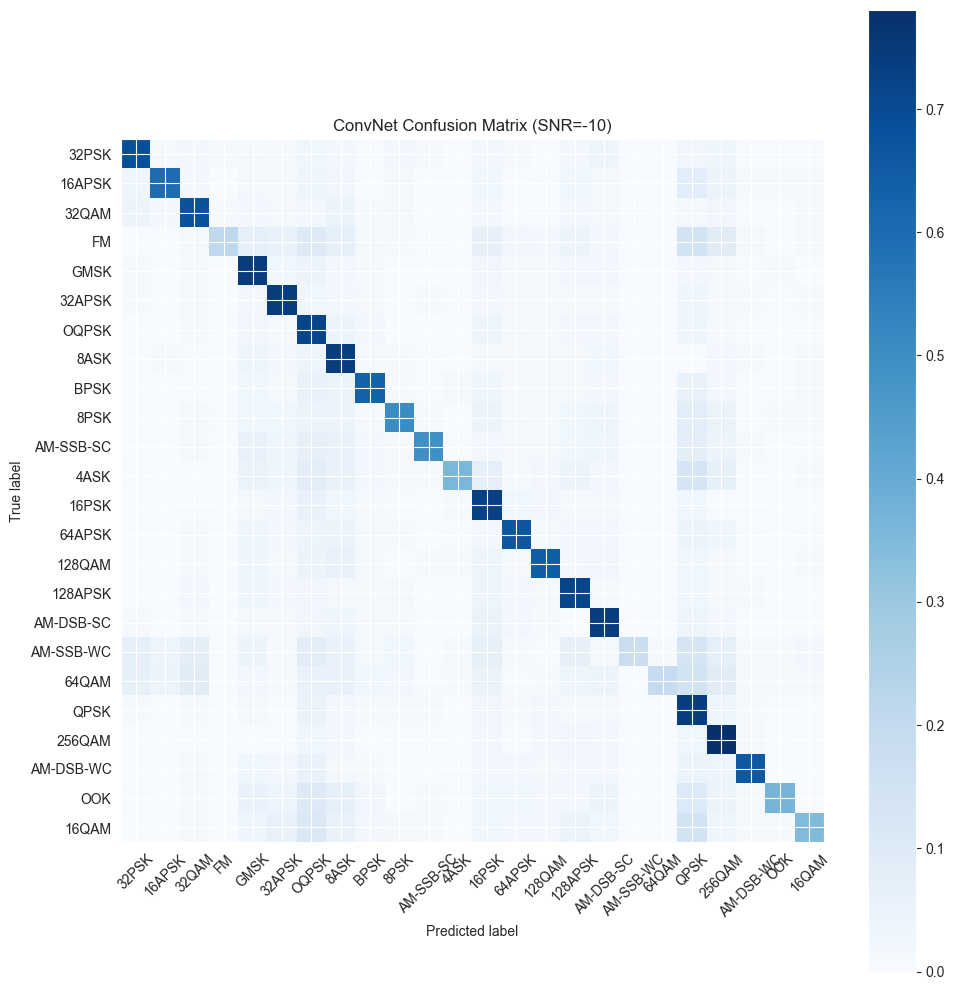

<Figure size 640x480 with 0 Axes>

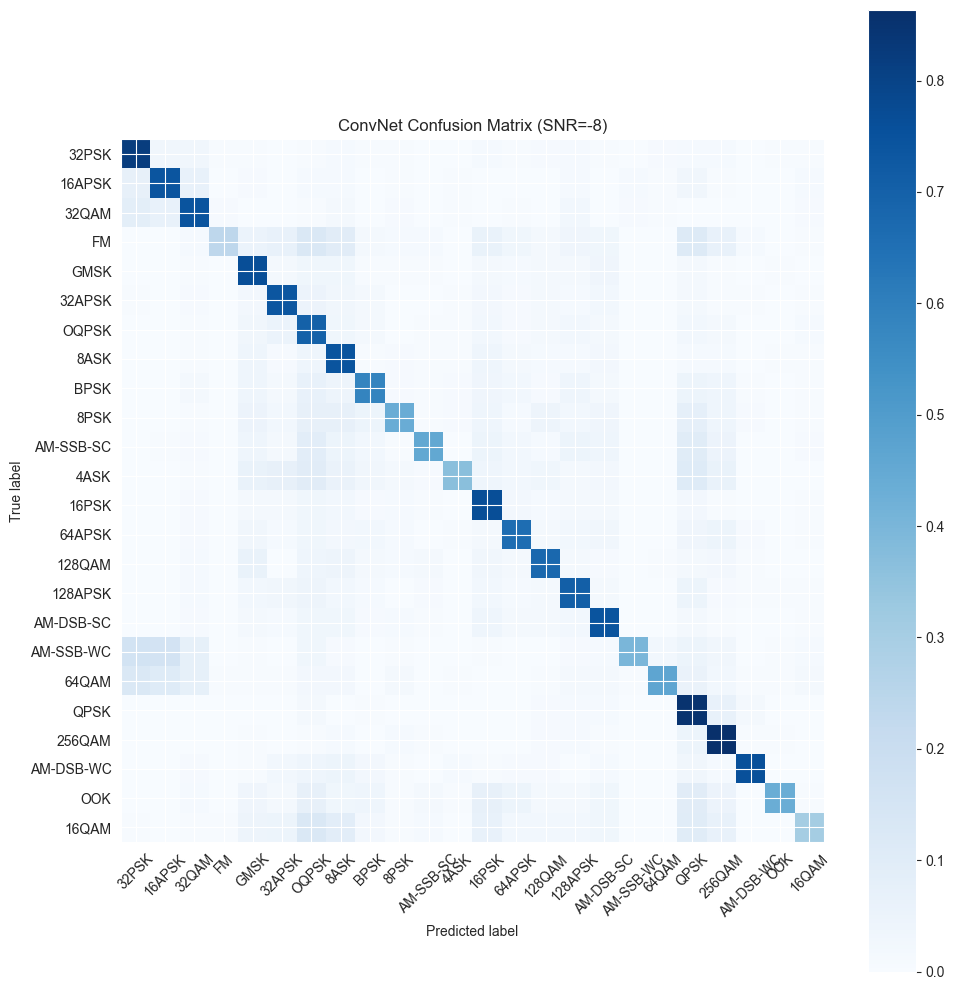

<Figure size 640x480 with 0 Axes>

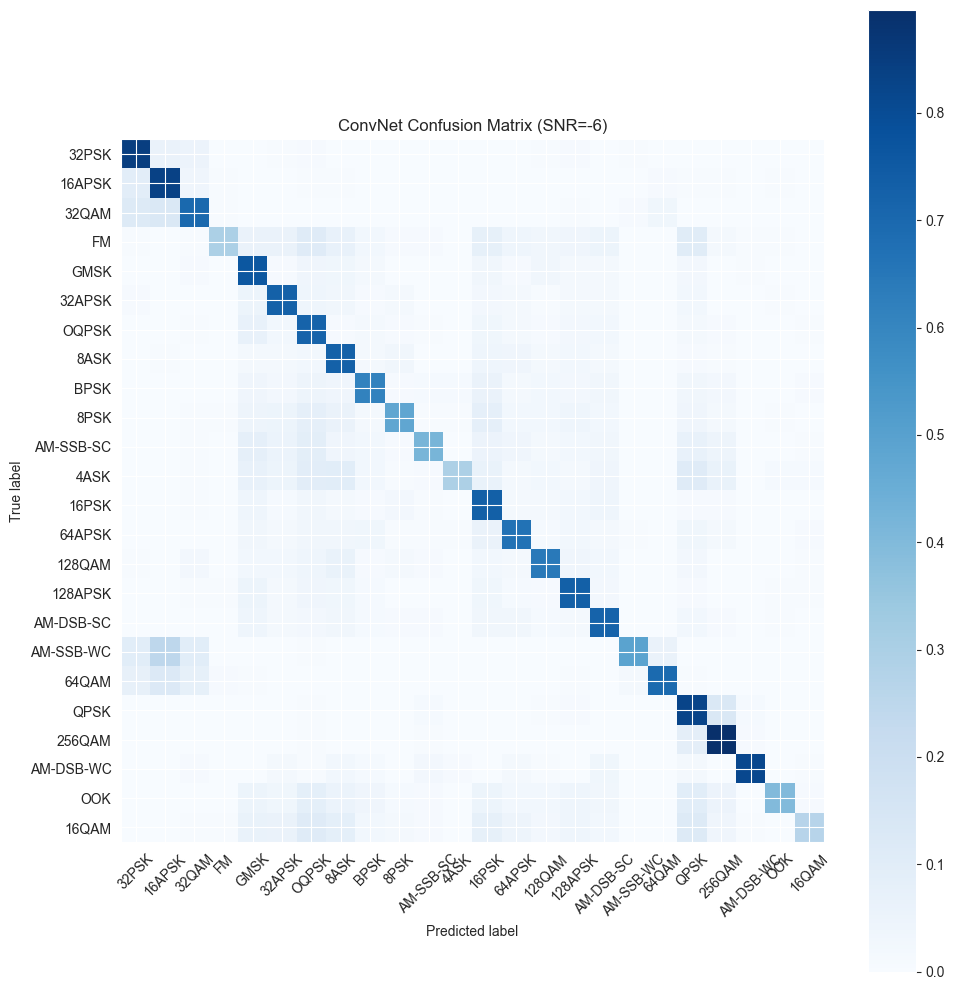

<Figure size 640x480 with 0 Axes>

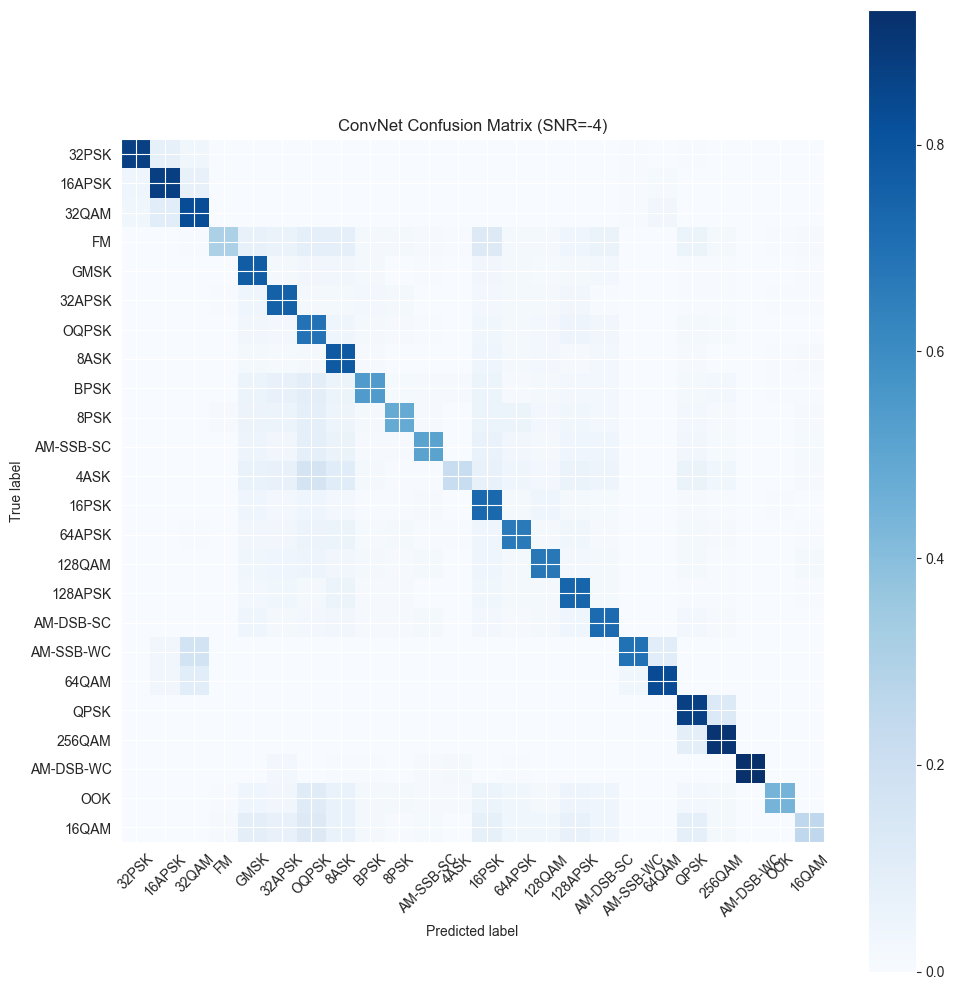

<Figure size 640x480 with 0 Axes>

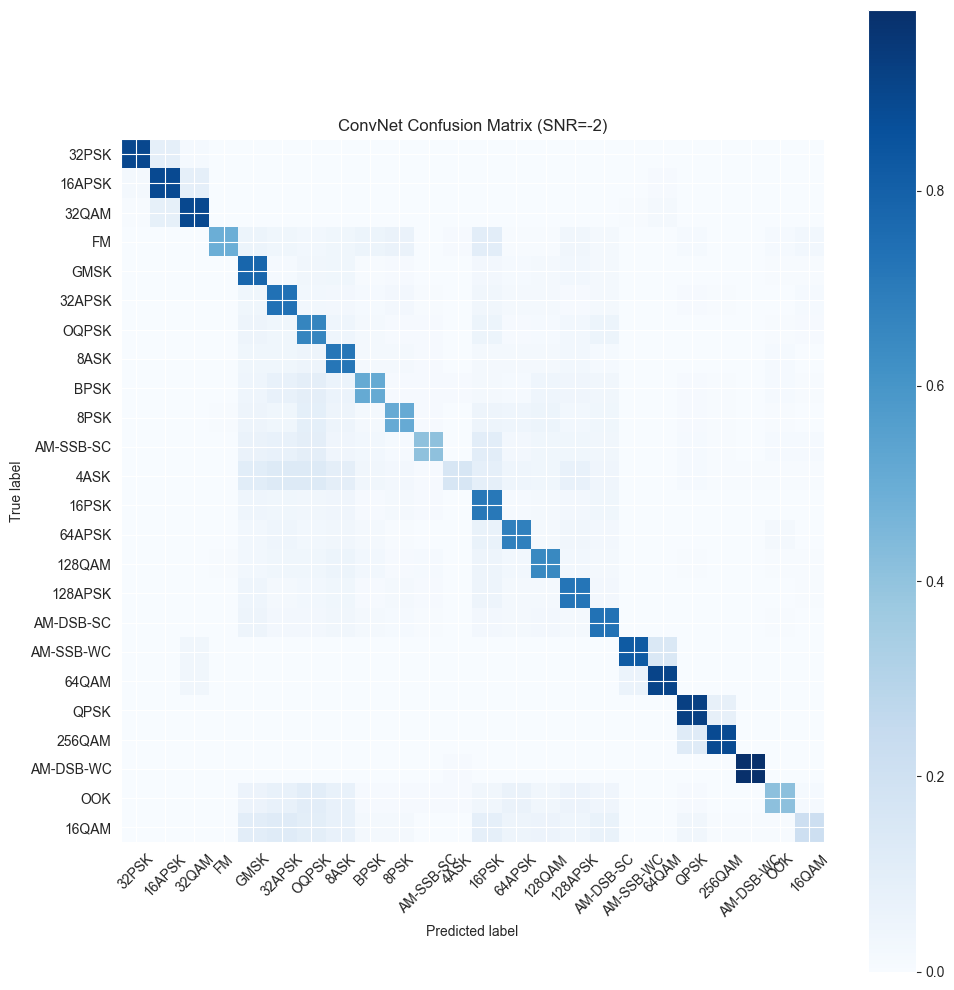

<Figure size 640x480 with 0 Axes>

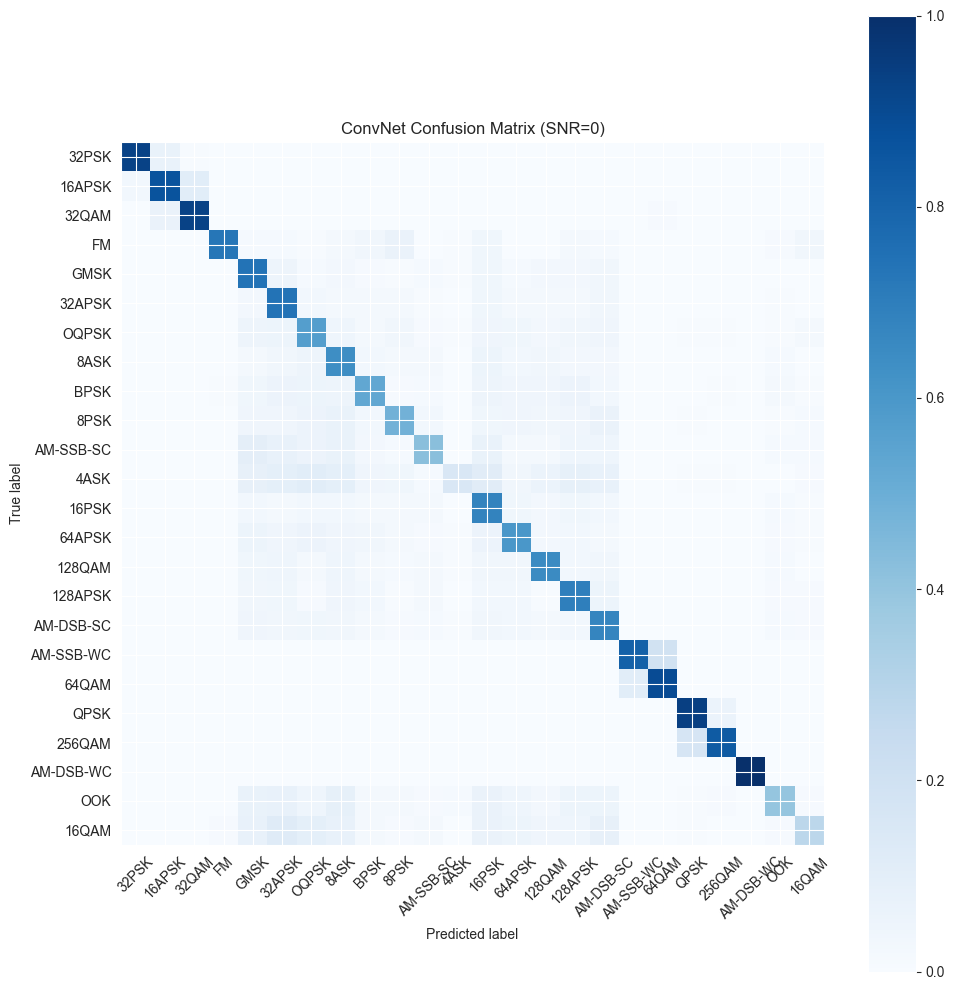

<Figure size 640x480 with 0 Axes>

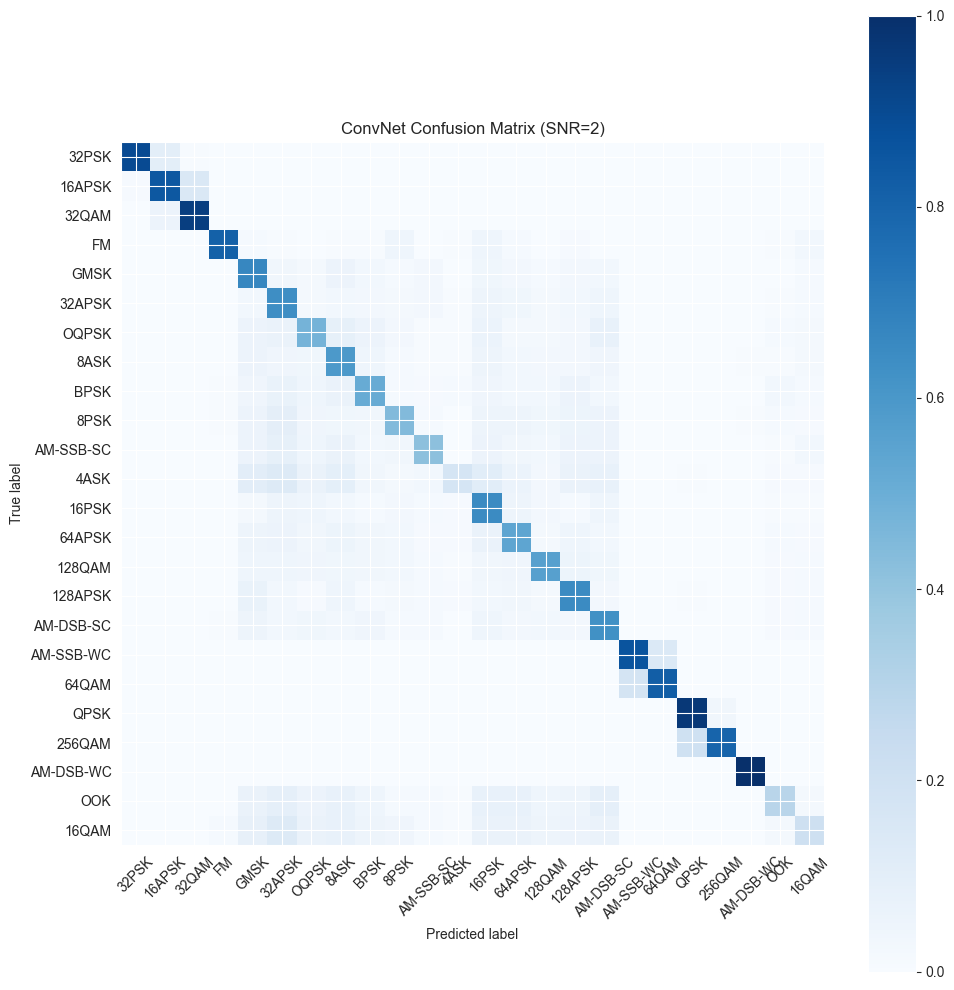

<Figure size 640x480 with 0 Axes>

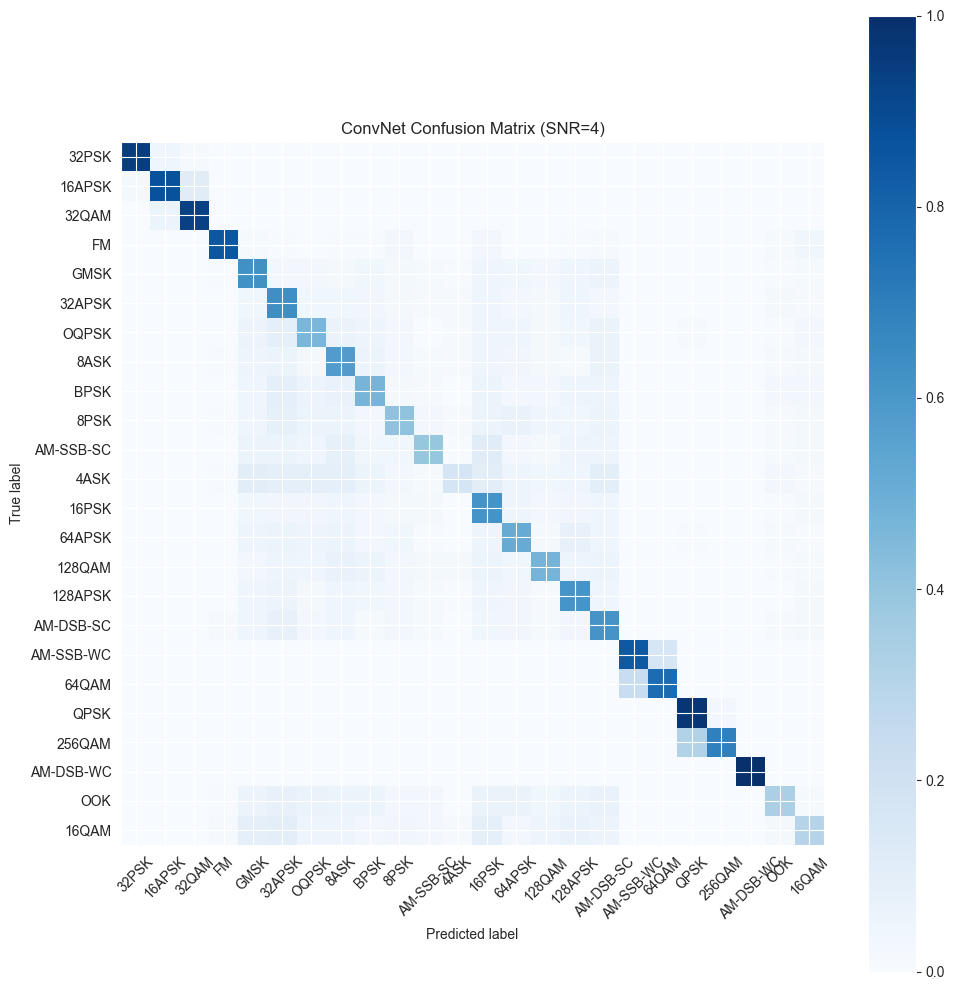

<Figure size 640x480 with 0 Axes>

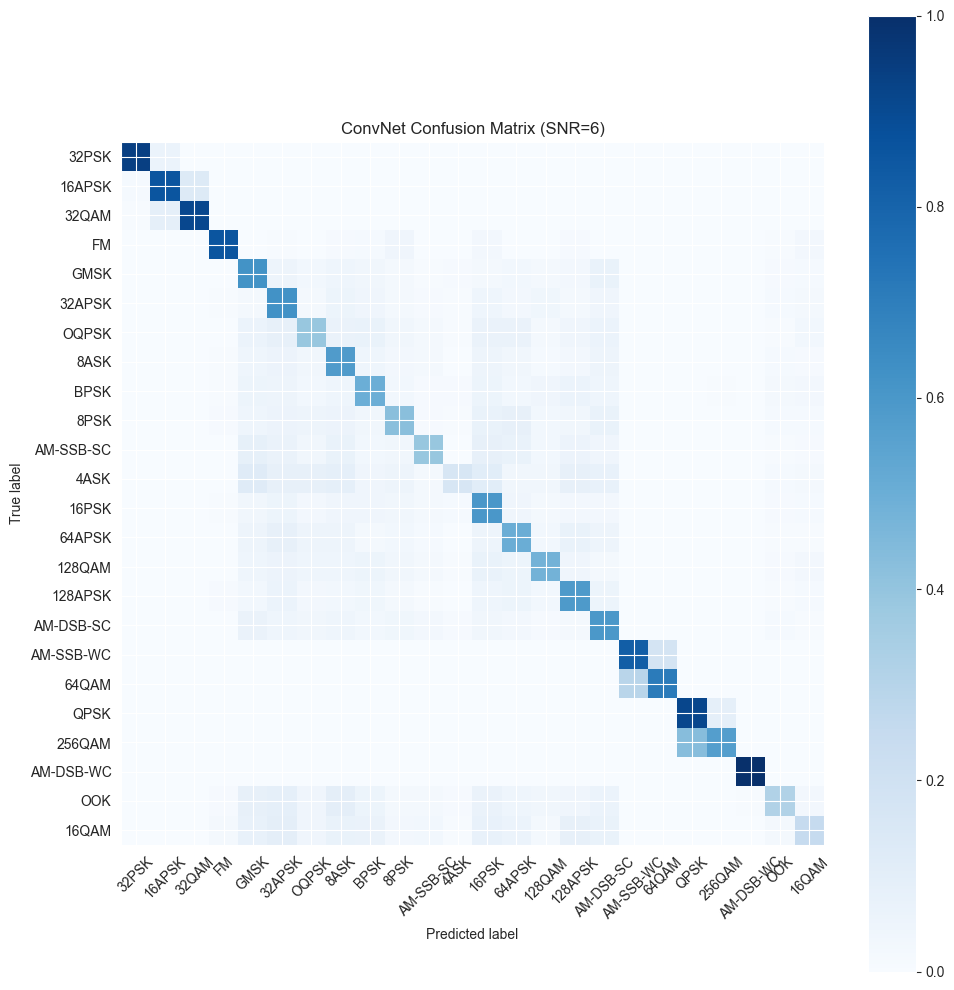

<Figure size 640x480 with 0 Axes>

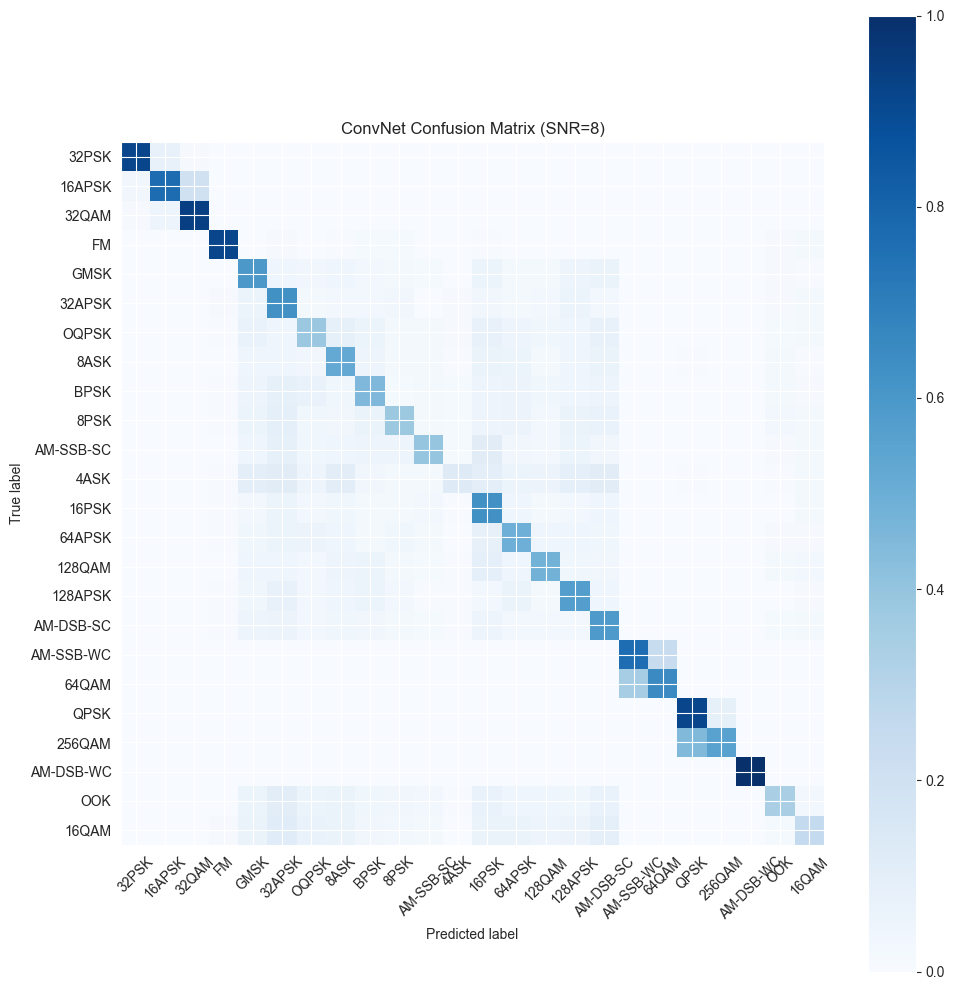

<Figure size 640x480 with 0 Axes>

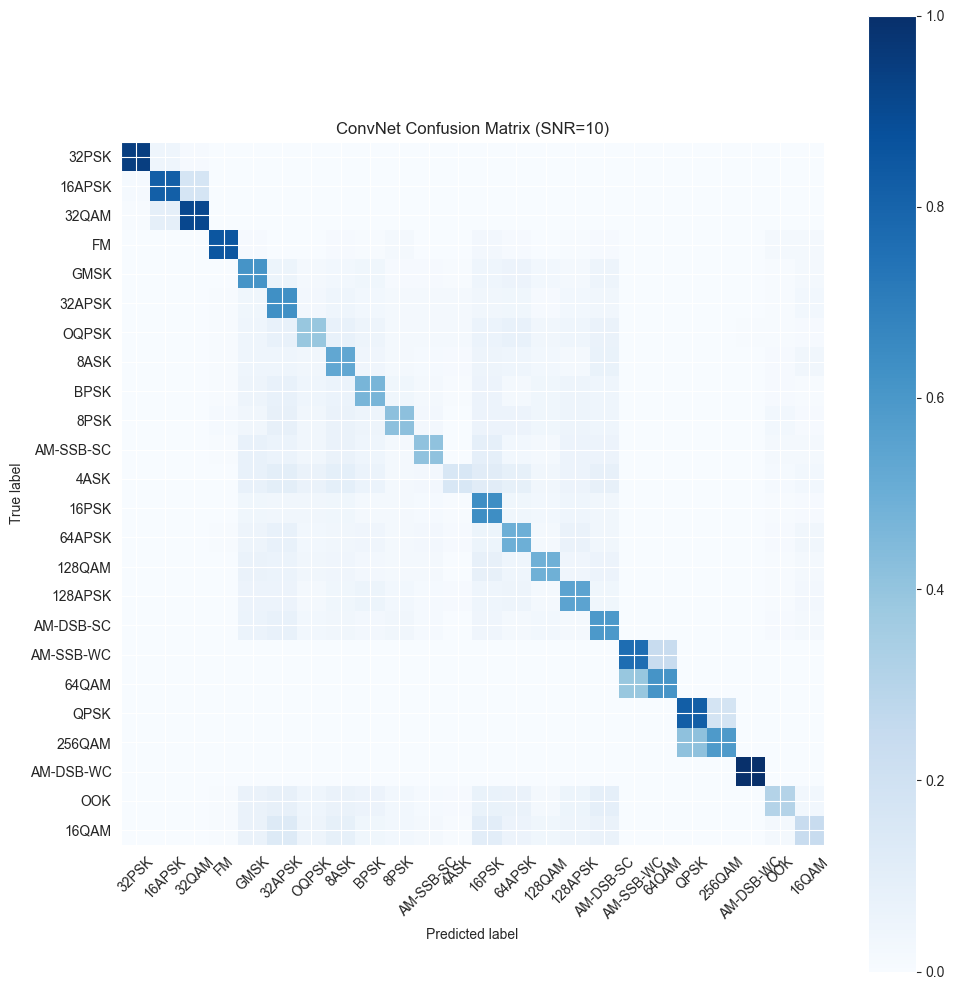

<Figure size 640x480 with 0 Axes>

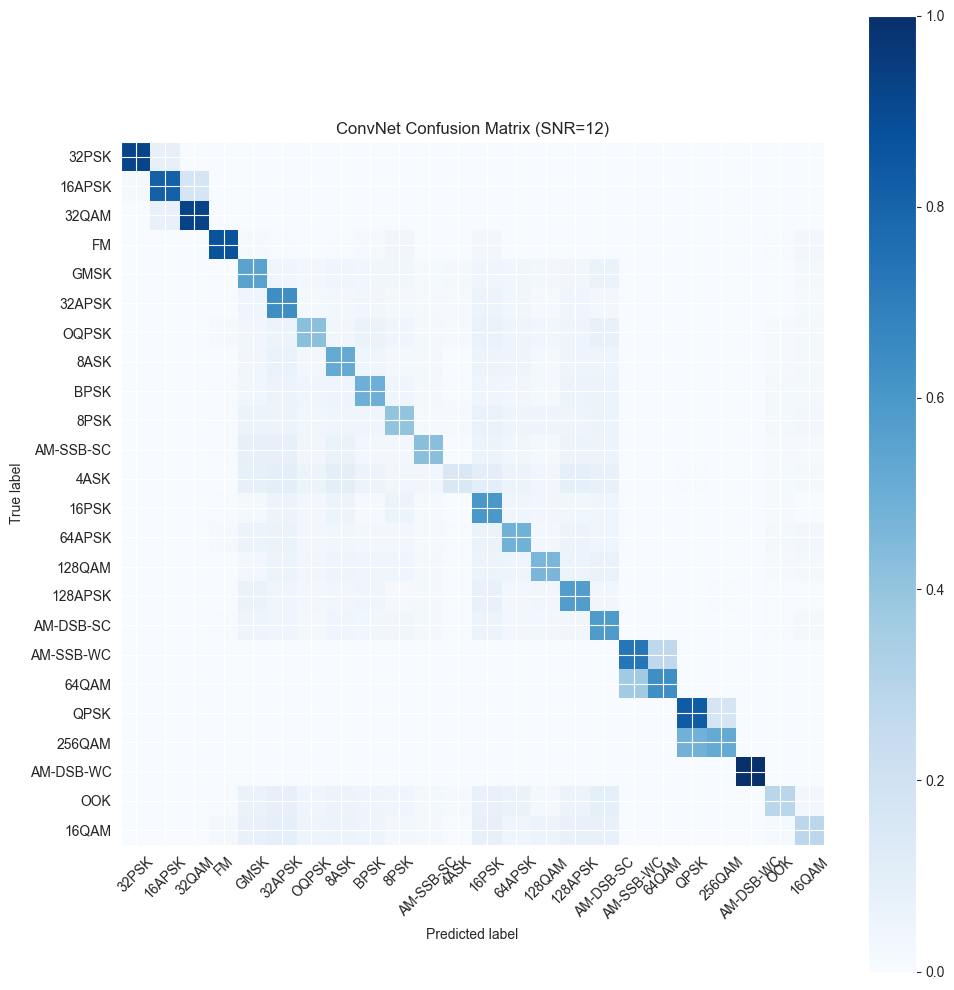

<Figure size 640x480 with 0 Axes>

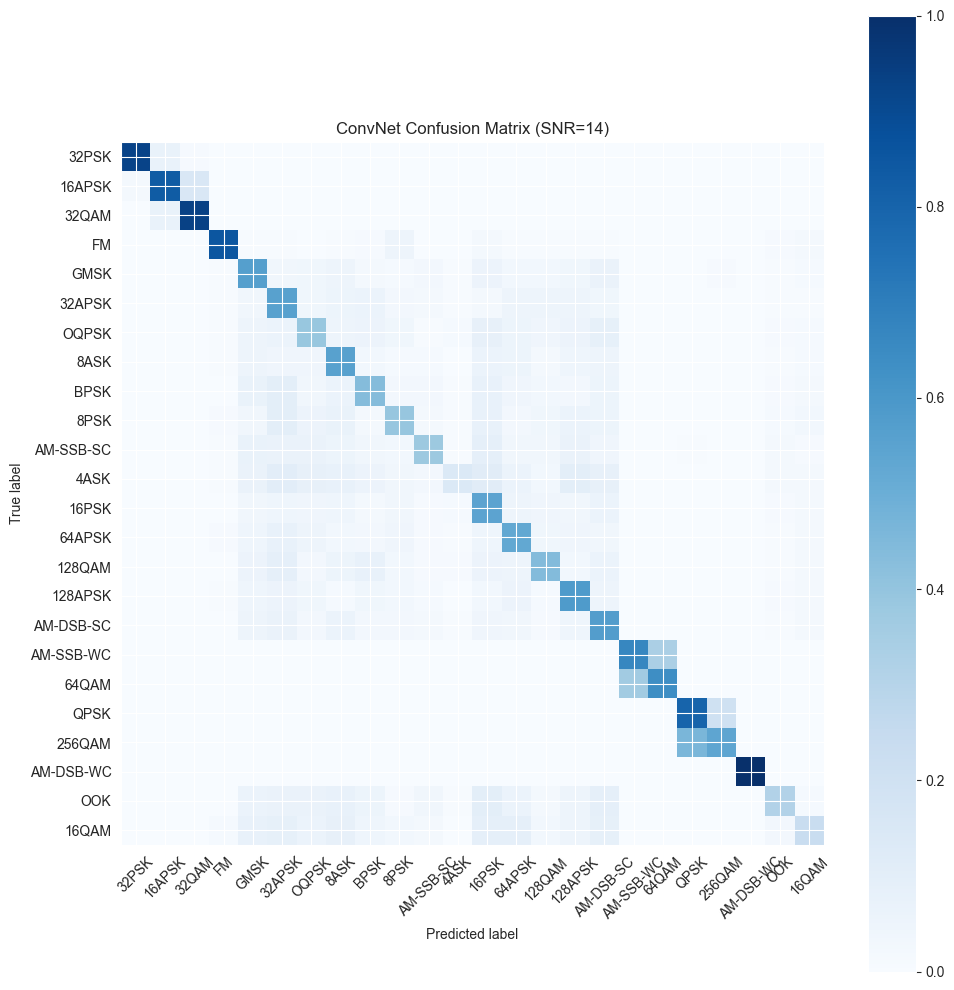

<Figure size 640x480 with 0 Axes>

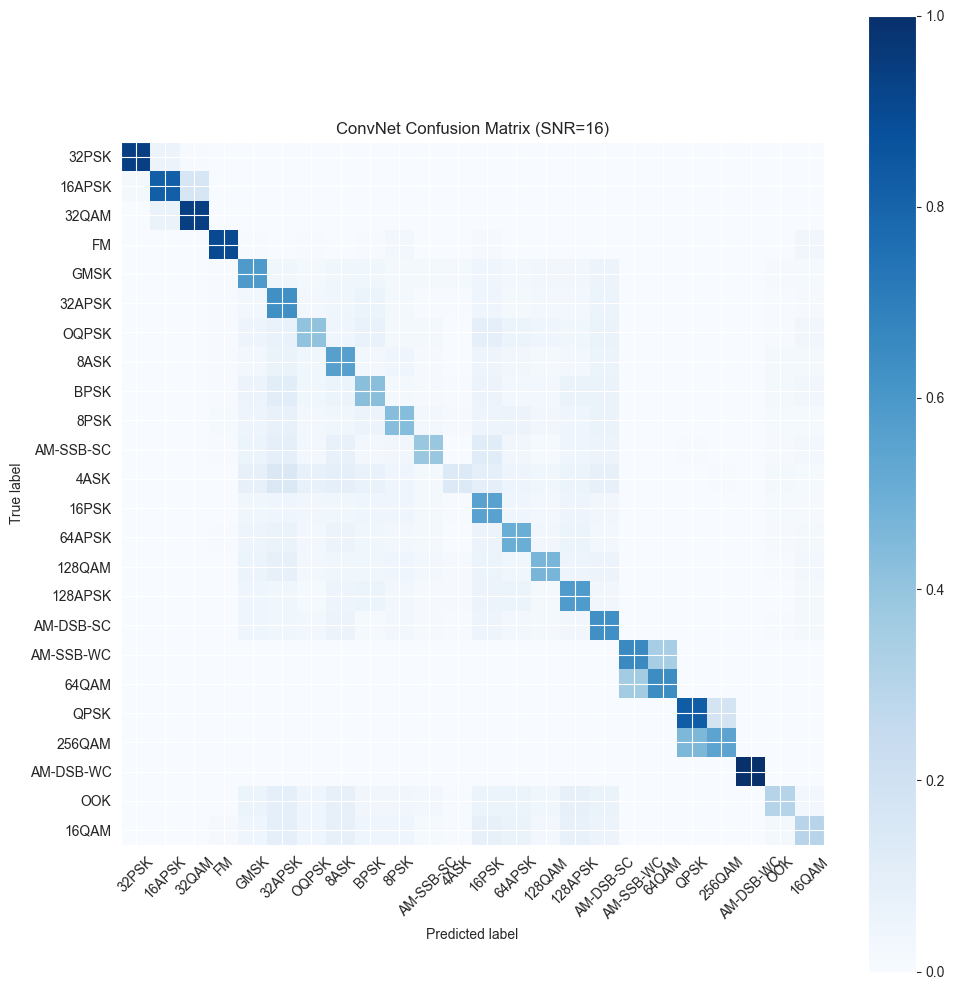

<Figure size 640x480 with 0 Axes>

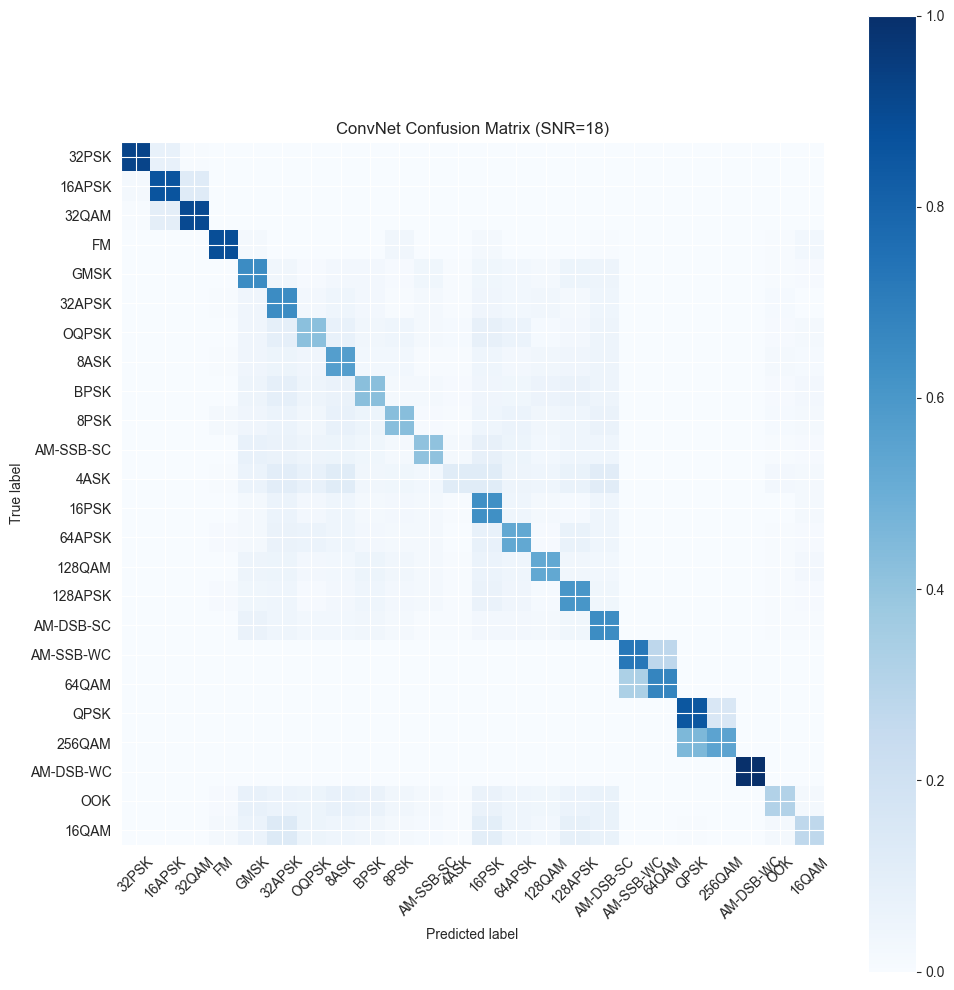

<Figure size 640x480 with 0 Axes>

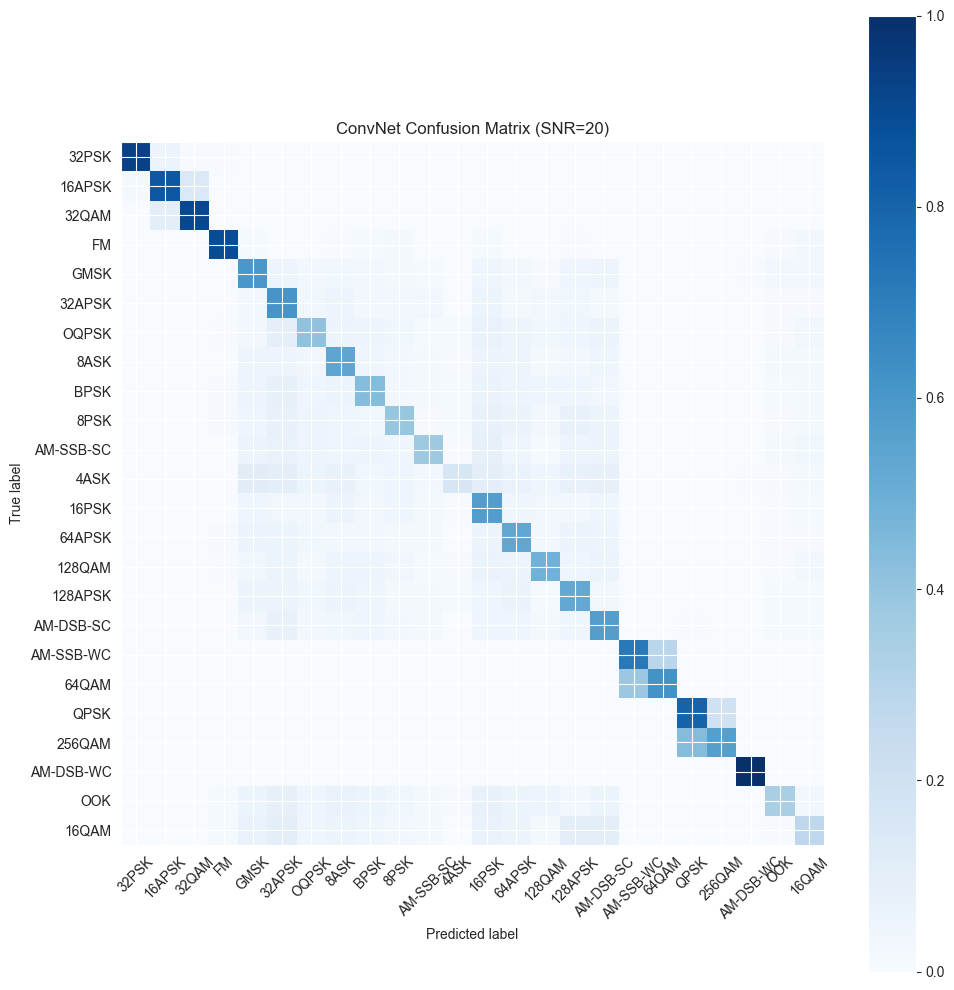

<Figure size 640x480 with 0 Axes>

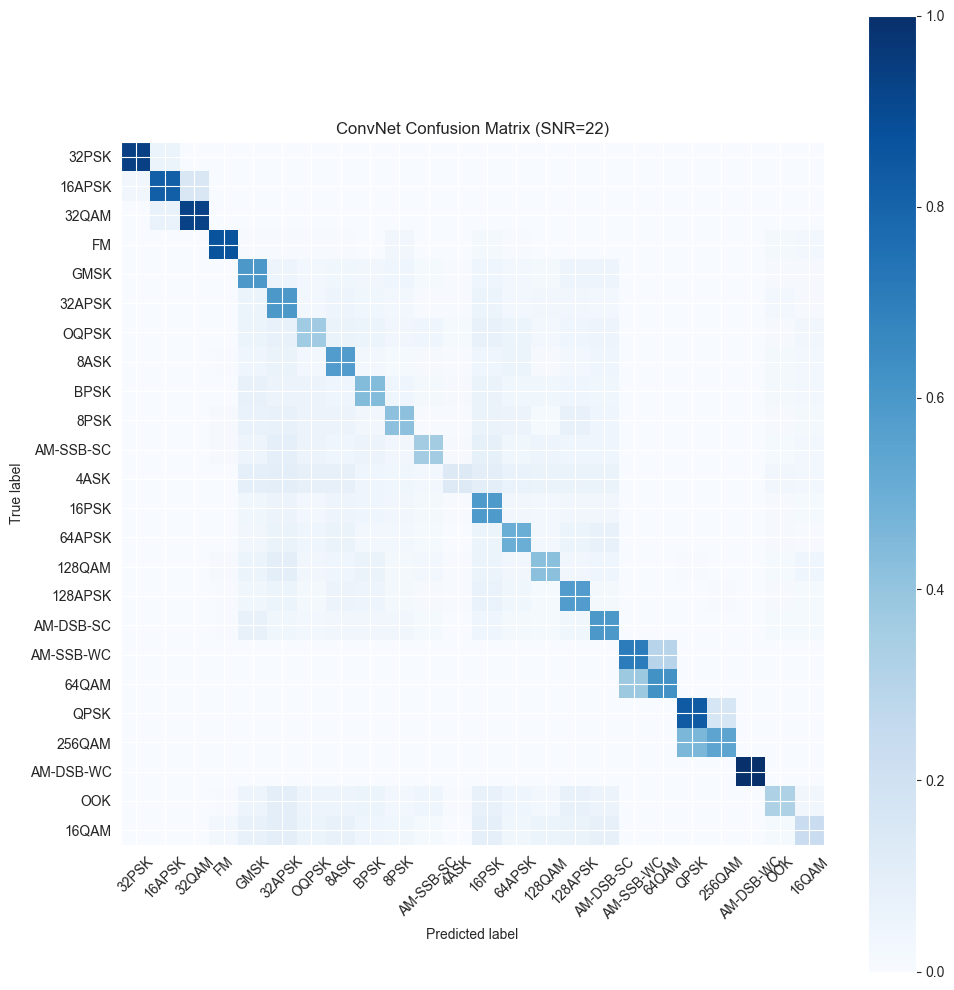

<Figure size 640x480 with 0 Axes>

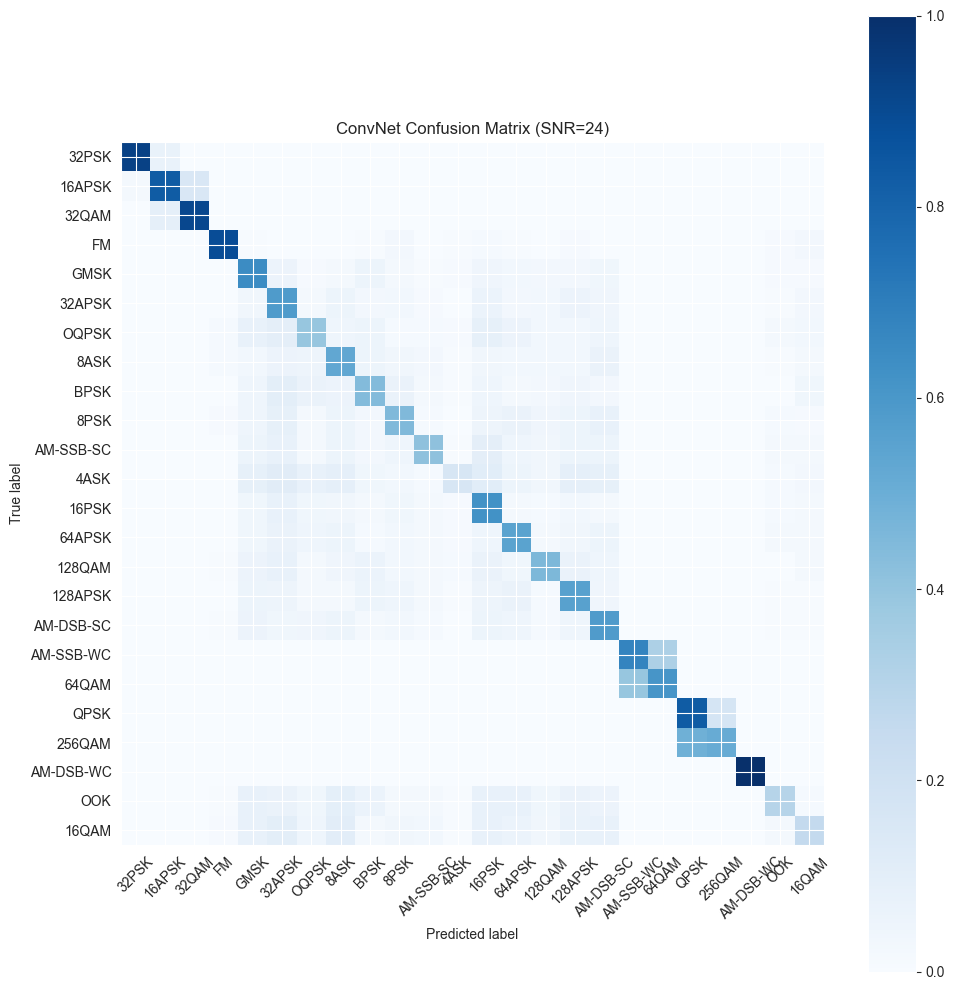

<Figure size 640x480 with 0 Axes>

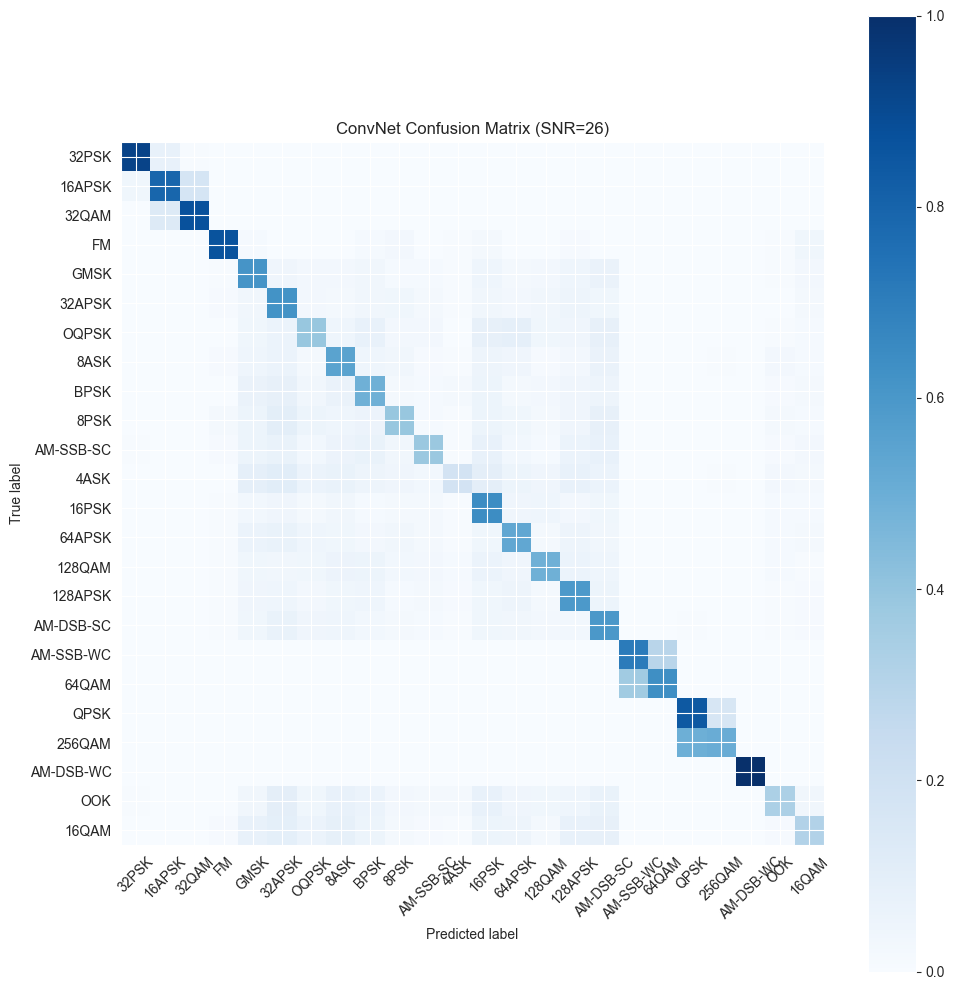

<Figure size 640x480 with 0 Axes>

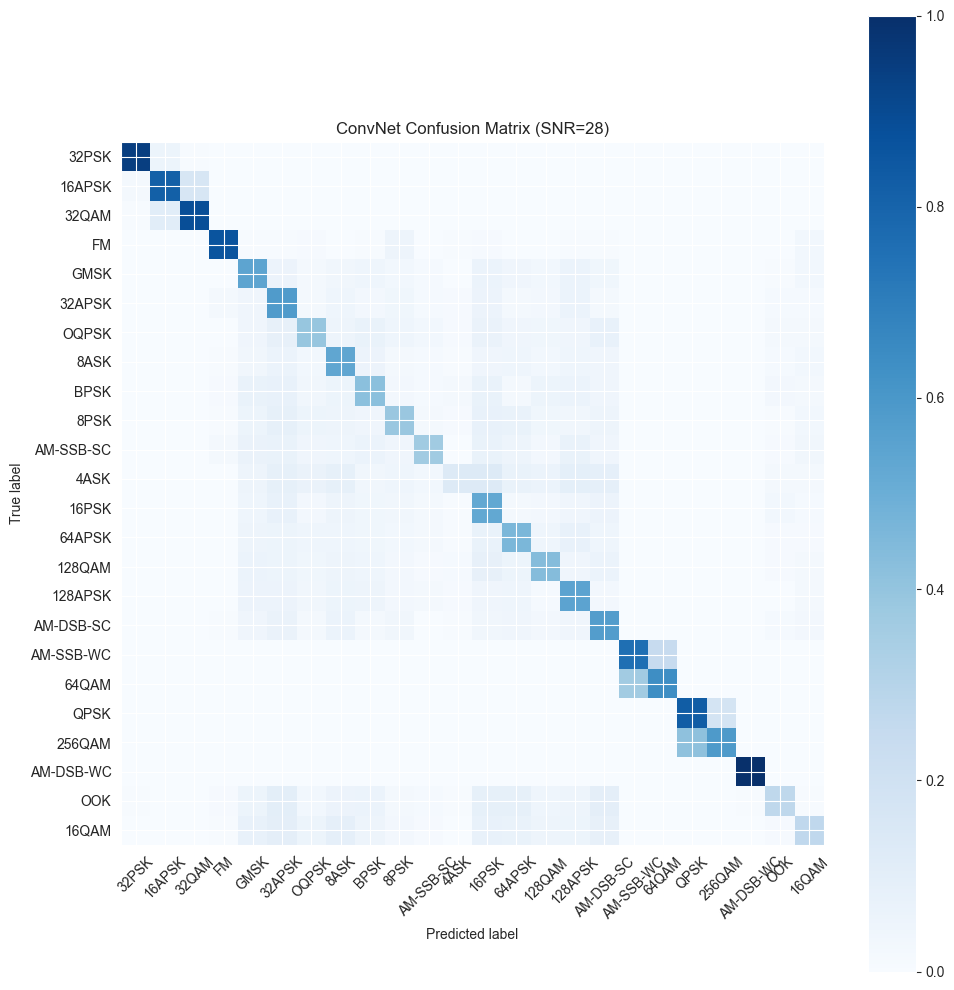

<Figure size 640x480 with 0 Axes>

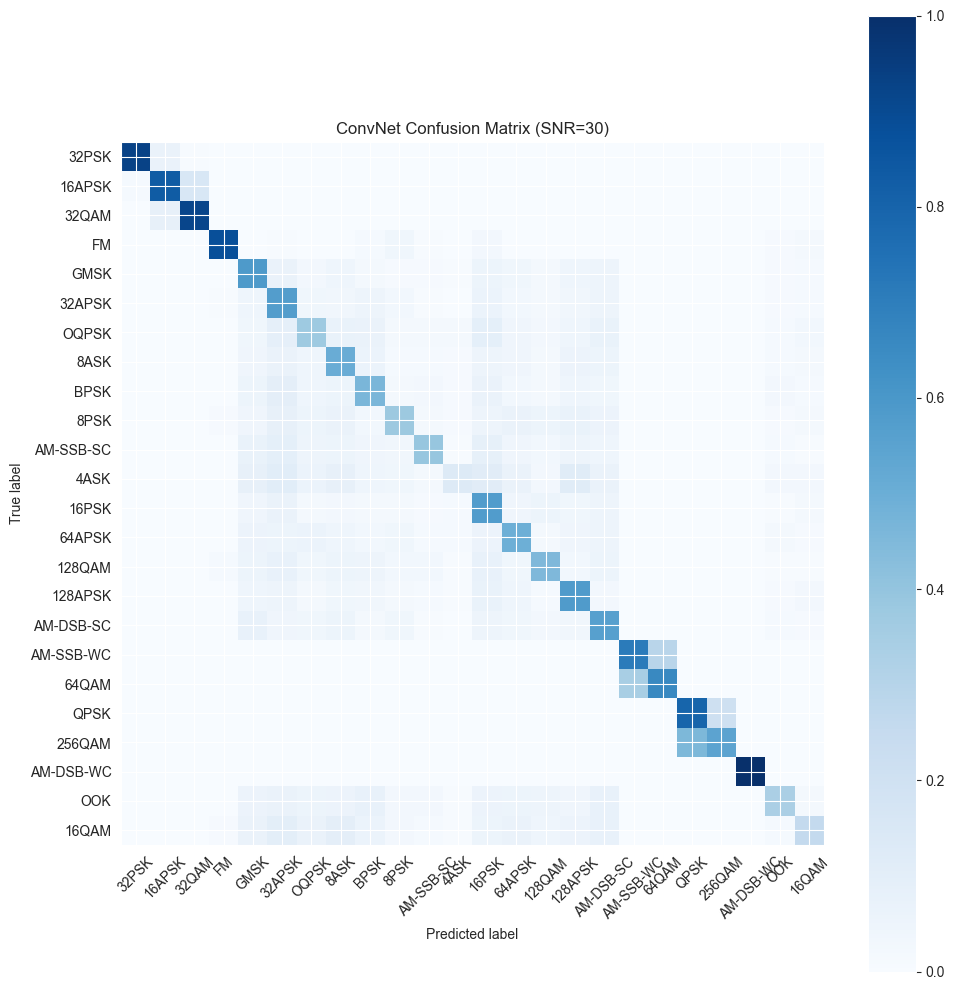

In [26]:
acc={}
SNRs = range(-20, 31, 2)
outputs_test = []
y_true = []
y_pred = []
model.eval()

for snr in SNRs:
    with torch.no_grad():
        for inputs, labels, snr_dataset in test_loader:
            inputs, labels, snr_dataset = inputs.to(device), labels.to(device), snr_dataset.to(device)
            indices = torch.where(snr_dataset == snr)
            X_test_snr = inputs[indices[0],:,:]
            Y_test_snr = labels[indices[0],:]
            outputs = model(X_test_snr)
            _, predicted = outputs.max(1)
            y_true.extend(Y_test_snr.max(1)[1].cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    for i in range(0, len(y_true)):
        j = y_true[i]
        k = y_pred[i]
        conf[j, k] += 1

    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title=f"ConvNet Confusion Matrix (SNR={snr})")

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print(f"Overall Accuracy {snr}: ", cor / (cor + ncor))
    acc[snr] = cor / (cor + ncor)
    y_true = []
    y_pred = []